# 4-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기

 
### [루브릭]

평가문항	상세기준
1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. 
    - 3가지 이상의 모델이 성공적으로 시도됨
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. 
    - gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. 
    - 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

### [학습 과정]
1) 데이터 준비와 확인  
2) 데이터로더 구성  
3) 모델구성을 위한 데이터 분석 및 가공  
4) 모델 구성 및 validation set 구성  
5) 모델 훈련 개시  
6) Loss Accuracy 그래프 시각화   
7) 학습된 Embedding 레이어 분석  
8) 한국어 Word2Vec 임베딩 활용하여 성능 개선  

### [결과 및 회고]

### 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/E04_SentimentAnalysis/ratings_train.txt')
test_data = pd.read_table('~/aiffel/E04_SentimentAnalysis/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 데이터로더 구성

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴


In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=70000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 데이터 중복 제거
    train_data = train_data.dropna(how='any')          # 결측치 제거       
    test_data.drop_duplicates(subset=['document'], inplace=True) # 데이터 중복 제거
    test_data = test_data.dropna(how = 'any')          # 결측치 제거
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # stopwords 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # stopwords 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(70000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
    
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))
print(len(word_to_index))

훈련 샘플 개수: 146182, 테스트 개수: 49157
53965


In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### 모델구성을 위한 데이터 분석 및 가공
* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [5]:
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [6]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성
num_tokens = [len(tokens) for tokens in total_data_text]

num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [7]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)


print(X_train.shape)

(146182, 41)


# 1. RNN - LSTM 사용 모델 

### 모델 구성 및 validation set 구성

In [8]:
vocab_size = len(word_to_index)   # 어휘 사전의 크기
word_vector_dim = 128  # 워드 벡터의 차원수 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(32))   
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         6907520   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                20608     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 6,928,673
Trainable params: 6,928,673
Non-trainable params: 0
_________________________________________________________________


In [9]:
# validation set 50000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 약 100000건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


### 모델 훈련 개시

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 10s 55ms/step - loss: 1.0333 - accuracy: 0.7734 - val_loss: 0.6094 - val_accuracy: 0.8445
Epoch 2/20
188/188 [==============================] - 10s 55ms/step - loss: 0.4499 - accuracy: 0.8700 - val_loss: 0.4110 - val_accuracy: 0.8504
Epoch 3/20
188/188 [==============================] - 10s 55ms/step - loss: 0.3331 - accuracy: 0.8987 - val_loss: 0.4078 - val_accuracy: 0.8491
Epoch 4/20
188/188 [==============================] - 11s 56ms/step - loss: 0.2872 - accuracy: 0.9160 - val_loss: 0.4182 - val_accuracy: 0.8473
Epoch 5/20
188/188 [==============================] - 11s 56ms/step - loss: 0.2521 - accuracy: 0.9286 - val_loss: 0.4202 - val_accuracy: 0.8475
Epoch 6/20
188/188 [==============================] - 11s 56ms/step - loss: 0.2270 - accuracy: 0.9379 - val_loss: 0.4415 - val_accuracy: 0.8418
Epoch 7/20
188/188 [==============================] - 11s 56ms/step - loss: 0.2057 - accuracy: 0.9455 - val_loss: 0.4651 - val_accuracy:

In [11]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6495 - accuracy: 0.8267
[0.6495411992073059, 0.8266574740409851]


### Loss Accuracy 그래프 시각화

In [12]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


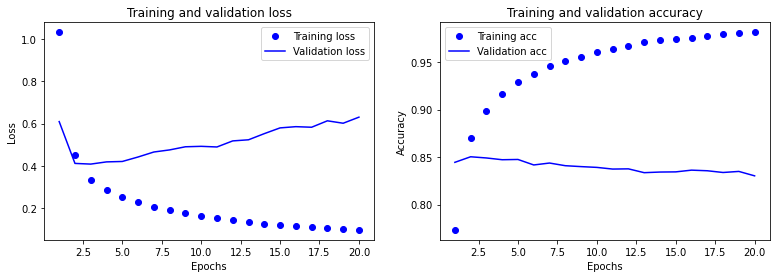

In [13]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 학습된 Embedding 레이어 분석

In [14]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(53965, 128)


In [15]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/project/AIFFEL/E04_SentimentAnalysis/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [16]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['좋']
vector

array([-0.19786546, -0.04943256, -0.07674669,  0.20678557, -0.18779239,
       -0.04084165, -0.13554753, -0.05734522, -0.15852782,  0.0227826 ,
       -0.08828393, -0.04263936,  0.05757281, -0.11911887, -0.00556321,
        0.10164688, -0.07197463,  0.00651307,  0.11538884,  0.07674778,
        0.17512874, -0.06478366,  0.21894884, -0.08305722,  0.30858615,
        0.14551038,  0.12680572,  0.16425231, -0.05901917, -0.02375334,
        0.01029019, -0.08072741,  0.16802087,  0.09036814,  0.10802275,
       -0.1056712 , -0.14267494, -0.14662246,  0.1220006 , -0.16221593,
        0.02718861, -0.00313632, -0.05866132, -0.03443403,  0.01182544,
        0.04324584, -0.14748925, -0.03744295, -0.06644654, -0.04726657,
       -0.04330624, -0.13499345,  0.0374801 , -0.05628301, -0.12609252,
       -0.05926226,  0.04688856, -0.01958591,  0.10666806,  0.09624846,
        0.2326641 , -0.07381903, -0.01707847,  0.13907154,  0.0759753 ,
       -0.07793642, -0.03092518, -0.0747443 , -0.15669405, -0.13

In [18]:
word_vectors.similar_by_word("좋")

[('재미있', 0.8387051820755005),
 ('교과서', 0.8299769163131714),
 ('원조', 0.7940458059310913),
 ('편안', 0.7931122779846191),
 ('짱', 0.7878395915031433),
 ('맘', 0.785856306552887),
 ('곰', 0.7804996967315674),
 ('아련', 0.7776148319244385),
 ('쩔', 0.7768019437789917),
 ('만족', 0.7742387652397156)]

### 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [19]:
import gensim
ko_model = gensim.models.Word2Vec.load('/home/ssac18/aiffel/E04_SentimentAnalysis/ko/ko.bin')
vector = ko_model['좋']
vector    

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 1.0640332 , -2.2912955 ,  3.3337867 , -2.1199276 , -3.0332334 ,
       -0.19465393, -2.481366  , -0.10735121,  2.5207045 ,  0.8627388 ,
       -0.45329845, -2.0046058 , -0.01572813,  0.5299075 ,  0.30947903,
       -0.9715863 , -0.9571187 , -0.60102916,  0.90976727, -1.9047512 ,
       -1.2195476 , -1.1592524 ,  0.8524444 ,  1.8657554 , -0.3389445 ,
       -0.49982402,  1.1301196 , -0.5019951 ,  1.1161596 , -1.1941459 ,
        0.940446  ,  1.2571095 , -0.30472234,  1.9796319 , -1.1565856 ,
       -0.23786964, -0.6009812 ,  0.5220223 ,  0.82051736, -1.5666542 ,
       -0.02252442, -1.4792949 ,  1.3666244 ,  1.4165231 ,  1.5582582 ,
        0.8805346 ,  3.4146652 , -1.9629716 ,  0.8763886 ,  1.3238906 ,
        0.4521591 ,  0.7075807 , -2.176243  , -0.20598859, -2.23883   ,
       -1.6937513 , -2.2974951 , -0.46340045,  0.942308  ,  0.6221677 ,
        1.5814389 , -0.9991125 , -1.0794336 ,  0.9742524 , -0.8817606 ,
        1.5110779 , -2.426482  ,  0.05825558,  2.1984208 ,  0.35

In [20]:
ko_model.similar_by_word("좋")

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('괜찮', 0.6849220991134644),
 ('나쁘', 0.6538200378417969),
 ('낫', 0.6441531777381897),
 ('좋아지', 0.6410495042800903),
 ('높', 0.5870170593261719),
 ('낮', 0.5831267833709717),
 ('알맞', 0.5798174142837524),
 ('많', 0.5643985867500305),
 ('귀찮', 0.5478721857070923),
 ('밝', 0.5269372463226318)]

In [21]:
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [22]:
from tensorflow.keras.initializers import Constant

vocab_size = len(word_to_index)   # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원수 

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(32))   
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(32, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           10793000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 10,823,913
Trainable params: 10,823,913
Non-trainable params: 0
_________________________________________________________________


In [24]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 19s 103ms/step - loss: 1.3594 - accuracy: 0.7144 - val_loss: 0.7109 - val_accuracy: 0.8101
Epoch 2/20
188/188 [==============================] - 19s 102ms/step - loss: 0.5202 - accuracy: 0.8336 - val_loss: 0.4391 - val_accuracy: 0.8442
Epoch 3/20
188/188 [==============================] - 19s 99ms/step - loss: 0.3947 - accuracy: 0.8706 - val_loss: 0.4047 - val_accuracy: 0.8517
Epoch 4/20
188/188 [==============================] - 19s 100ms/step - loss: 0.3397 - accuracy: 0.8948 - val_loss: 0.3957 - val_accuracy: 0.8540
Epoch 5/20
188/188 [==============================] - 19s 99ms/step - loss: 0.2991 - accuracy: 0.9109 - val_loss: 0.4010 - val_accuracy: 0.8530
Epoch 6/20
188/188 [==============================] - 19s 100ms/step - loss: 0.2702 - accuracy: 0.9228 - val_loss: 0.4006 - val_accuracy: 0.8540
Epoch 7/20
188/188 [==============================] - 19s 99ms/step - loss: 0.2456 - accuracy: 0.9321 - val_loss: 0.4166 - val_accur

In [25]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5938 - accuracy: 0.8359
[0.593834638595581, 0.8359338641166687]


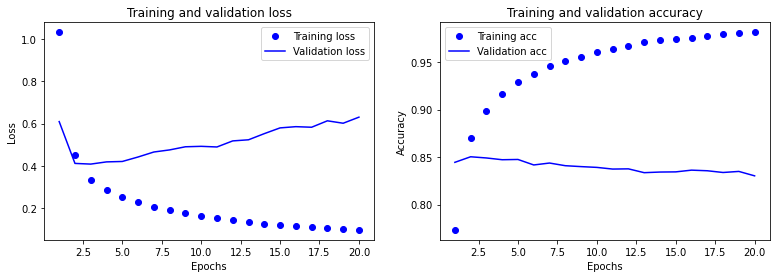

In [26]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.5,1)
plt.legend()

plt.show()

---
# 2. 1-D CNN  - GlobalMaxPooling1D() 사용 모델

### 모델 구성 및 validation set 구성

In [27]:
vocab_size = len(word_to_index)
word_vector_dim = 128   

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(32, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         6907520   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 32)          28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          3600      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)               

In [28]:
X_val = X_train[:50000]   
y_val = y_train[:50000]


partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


In [29]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 24s 128ms/step - loss: 0.8989 - accuracy: 0.7211 - val_loss: 0.5643 - val_accuracy: 0.8440
Epoch 2/20
188/188 [==============================] - 10s 52ms/step - loss: 0.4513 - accuracy: 0.8665 - val_loss: 0.3817 - val_accuracy: 0.8527
Epoch 3/20
188/188 [==============================] - 10s 55ms/step - loss: 0.3129 - accuracy: 0.8992 - val_loss: 0.3711 - val_accuracy: 0.8524
Epoch 4/20
188/188 [==============================] - 10s 53ms/step - loss: 0.2601 - accuracy: 0.9211 - val_loss: 0.3964 - val_accuracy: 0.8510
Epoch 5/20
188/188 [==============================] - 10s 53ms/step - loss: 0.2154 - accuracy: 0.9382 - val_loss: 0.4286 - val_accuracy: 0.8468
Epoch 6/20
188/188 [==============================] - 10s 55ms/step - loss: 0.1775 - accuracy: 0.9531 - val_loss: 0.4579 - val_accuracy: 0.8448
Epoch 7/20
188/188 [==============================] - 10s 54ms/step - loss: 0.1480 - accuracy: 0.9635 - val_loss: 0.5053 - val_accuracy

In [30]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 1.0239 - accuracy: 0.8231
[1.0239043235778809, 0.8230770826339722]


In [31]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Loss Accuracy 그래프 시각화

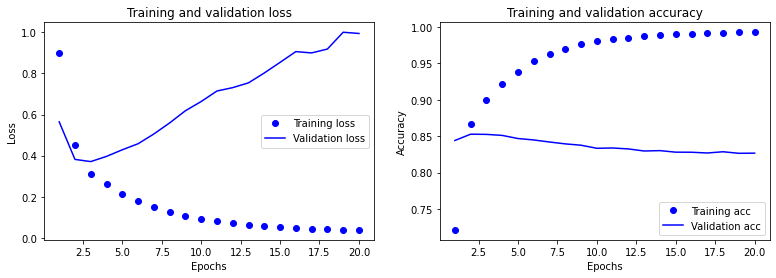

In [32]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 학습된 Embedding 레이어 분석

In [33]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(53965, 128)


In [34]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/project/AIFFEL/E04_SentimentAnalysis/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [35]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['좋']
vector

array([ 8.94278735e-02, -1.01409733e-01, -6.87256572e-04, -1.19340923e-02,
        2.47566737e-02,  9.55714472e-03, -3.14634456e-03,  4.77062538e-02,
        1.11028932e-01,  9.45389941e-02,  7.22624585e-02,  1.37822717e-01,
        1.35477483e-02,  1.67103447e-02,  6.75566867e-02,  7.16362447e-02,
       -1.33139327e-01, -8.12350512e-02, -3.00749671e-03,  5.55216558e-02,
       -9.01782066e-02,  8.16599354e-02,  1.07060179e-01,  2.07077656e-02,
       -7.53600746e-02, -6.05151132e-02, -1.14974350e-01, -1.51045434e-02,
       -1.15221098e-01, -2.59417631e-02, -4.61937003e-02,  5.14470227e-02,
        4.14776281e-02,  7.36930668e-02, -6.19329475e-02,  3.60633284e-02,
        5.50461859e-02, -3.72081399e-02,  4.74672578e-02,  5.21528423e-02,
        1.06541619e-01,  9.64723676e-02,  8.75071809e-03,  1.04567476e-01,
        5.59916310e-02, -7.56109506e-02, -5.10882959e-02,  3.19106430e-02,
       -1.25858665e-01,  3.60811353e-02, -2.52755191e-02,  2.04065621e-01,
        4.16748039e-02, -

In [36]:
word_vectors.similar_by_word("좋")

[('!!!!!!!~~~~~~~~~', 0.6914083957672119),
 ('이쁜', 0.6786265969276428),
 ('이지훈', 0.6621902585029602),
 ('라오', 0.6612460017204285),
 ('감이', 0.6606247425079346),
 ('마바리', 0.6570593118667603),
 ('여라', 0.6560837626457214),
 ('군대', 0.6544933319091797),
 ('앴', 0.652912437915802),
 ('백룡', 0.6496391892433167)]

### 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [37]:
import gensim
ko_model = gensim.models.Word2Vec.load('/home/ssac18/aiffel/E04_SentimentAnalysis/ko/ko.bin')
vector = ko_model['좋']
vector    

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 1.0640332 , -2.2912955 ,  3.3337867 , -2.1199276 , -3.0332334 ,
       -0.19465393, -2.481366  , -0.10735121,  2.5207045 ,  0.8627388 ,
       -0.45329845, -2.0046058 , -0.01572813,  0.5299075 ,  0.30947903,
       -0.9715863 , -0.9571187 , -0.60102916,  0.90976727, -1.9047512 ,
       -1.2195476 , -1.1592524 ,  0.8524444 ,  1.8657554 , -0.3389445 ,
       -0.49982402,  1.1301196 , -0.5019951 ,  1.1161596 , -1.1941459 ,
        0.940446  ,  1.2571095 , -0.30472234,  1.9796319 , -1.1565856 ,
       -0.23786964, -0.6009812 ,  0.5220223 ,  0.82051736, -1.5666542 ,
       -0.02252442, -1.4792949 ,  1.3666244 ,  1.4165231 ,  1.5582582 ,
        0.8805346 ,  3.4146652 , -1.9629716 ,  0.8763886 ,  1.3238906 ,
        0.4521591 ,  0.7075807 , -2.176243  , -0.20598859, -2.23883   ,
       -1.6937513 , -2.2974951 , -0.46340045,  0.942308  ,  0.6221677 ,
        1.5814389 , -0.9991125 , -1.0794336 ,  0.9742524 , -0.8817606 ,
        1.5110779 , -2.426482  ,  0.05825558,  2.1984208 ,  0.35

In [38]:
ko_model.similar_by_word("좋")

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('괜찮', 0.6849220991134644),
 ('나쁘', 0.6538200378417969),
 ('낫', 0.6441531777381897),
 ('좋아지', 0.6410495042800903),
 ('높', 0.5870170593261719),
 ('낮', 0.5831267833709717),
 ('알맞', 0.5798174142837524),
 ('많', 0.5643985867500305),
 ('귀찮', 0.5478721857070923),
 ('밝', 0.5269372463226318)]

In [39]:
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [40]:
from tensorflow.keras.initializers import Constant

vocab_size = len(word_to_index)   # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원수 

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           10793000  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)               

In [41]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 31s 163ms/step - loss: 0.9770 - accuracy: 0.6513 - val_loss: 0.7043 - val_accuracy: 0.7657
Epoch 2/20
188/188 [==============================] - 18s 98ms/step - loss: 0.5786 - accuracy: 0.7915 - val_loss: 0.4560 - val_accuracy: 0.8201
Epoch 3/20
188/188 [==============================] - 18s 98ms/step - loss: 0.4219 - accuracy: 0.8390 - val_loss: 0.4013 - val_accuracy: 0.8341
Epoch 4/20
188/188 [==============================] - 18s 98ms/step - loss: 0.3634 - accuracy: 0.8673 - val_loss: 0.3793 - val_accuracy: 0.8430
Epoch 5/20
188/188 [==============================] - 18s 98ms/step - loss: 0.3235 - accuracy: 0.8863 - val_loss: 0.3815 - val_accuracy: 0.8445
Epoch 6/20
188/188 [==============================] - 19s 100ms/step - loss: 0.2869 - accuracy: 0.9037 - val_loss: 0.3823 - val_accuracy: 0.8461
Epoch 7/20
188/188 [==============================] - 18s 98ms/step - loss: 0.2571 - accuracy: 0.9173 - val_loss: 0.4010 - val_accurac

In [42]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.8933 - accuracy: 0.8244
[0.8933070302009583, 0.8244197368621826]


In [43]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


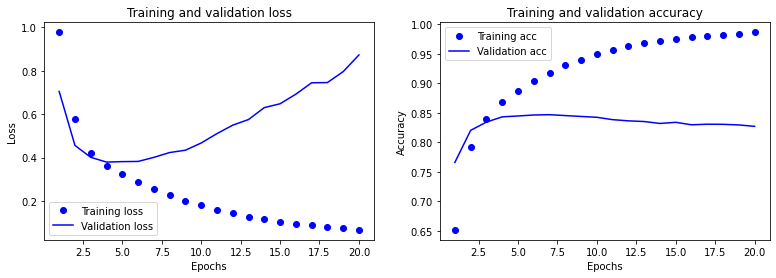

In [44]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.5,1)
plt.legend()

plt.show()

---
# 3. GlobalMaxPooling1D() 하나만 사용한 모델

### 모델 구성 및 validation set 구성

In [45]:
vocab_size = len(word_to_index)  
word_vector_dim = 128   

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         6907520   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                2064      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 6,909,601
Trainable params: 6,909,601
Non-trainable params: 0
_________________________________________________________________


In [46]:
X_val = X_train[:50000]   
y_val = y_train[:50000]

partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


In [47]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 10s 52ms/step - loss: 1.4124 - accuracy: 0.7078 - val_loss: 0.7139 - val_accuracy: 0.7756
Epoch 2/20
188/188 [==============================] - 10s 51ms/step - loss: 0.6839 - accuracy: 0.7295 - val_loss: 0.6384 - val_accuracy: 0.7561
Epoch 3/20
188/188 [==============================] - 10s 52ms/step - loss: 0.5902 - accuracy: 0.7765 - val_loss: 0.5377 - val_accuracy: 0.8103
Epoch 4/20
188/188 [==============================] - 10s 52ms/step - loss: 0.5296 - accuracy: 0.8200 - val_loss: 0.5022 - val_accuracy: 0.8225
Epoch 5/20
188/188 [==============================] - 9s 49ms/step - loss: 0.4986 - accuracy: 0.8343 - val_loss: 0.4816 - val_accuracy: 0.8270
Epoch 6/20
188/188 [==============================] - 9s 49ms/step - loss: 0.4748 - accuracy: 0.8427 - val_loss: 0.4663 - val_accuracy: 0.8309
Epoch 7/20
188/188 [==============================] - 10s 52ms/step - loss: 0.4555 - accuracy: 0.8504 - val_loss: 0.4547 - val_accuracy: 0

In [48]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4186 - accuracy: 0.8436
[0.41855865716934204, 0.843582808971405]


In [49]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### Loss Accuracy 그래프 시각화

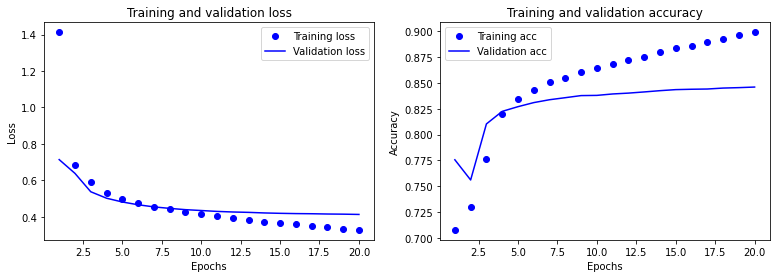

In [50]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(-1, 1.5)
plt.legend()
ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.5,1)
plt.legend()

plt.show()

### 학습된 Embedding 레이어 분석

In [51]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(53965, 128)


In [52]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/project/AIFFEL/E04_SentimentAnalysis/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [53]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['좋']
vector

array([-2.73595989e-01,  1.28963903e-01, -4.37450185e-02, -3.09685823e-02,
        5.85968018e-01, -5.73901052e-04,  4.06841278e-01,  2.45976701e-01,
       -4.36739326e-02, -4.41155210e-02,  1.49519995e-01,  1.72869384e-01,
        5.43648779e-01, -3.82801406e-02,  3.92217450e-02, -1.92482583e-02,
       -3.39721926e-02, -6.89639300e-02, -4.60293479e-02, -3.22912335e-02,
       -2.50057055e-04, -3.47712375e-02, -6.03972599e-02, -2.64950618e-02,
        7.39233941e-02,  9.66082811e-02,  2.64018625e-01,  1.46134654e-02,
        2.49843001e-01,  1.56833399e-02, -4.41352986e-02,  2.14148879e-01,
        1.00040436e-03, -5.19975089e-02,  9.09316614e-02,  7.32187182e-03,
        2.26099908e-01, -3.56179327e-02, -3.01408768e-01, -3.07239443e-02,
        3.47330868e-02,  6.73450470e-01, -4.83873719e-03, -1.66076317e-01,
       -1.45329773e-01, -2.99111724e-01, -1.86041519e-01,  6.57051444e-01,
        6.99426457e-02,  3.05716783e-01, -3.92886288e-02,  2.15320438e-01,
       -3.14422660e-02, -

In [54]:
word_vectors.similar_by_word("좋")

[('만찬', 0.6684145927429199),
 ('참신', 0.6457814574241638),
 ('집요', 0.6426976323127747),
 ('bbbbbbbbbbbbbbbbbbbb', 0.6334915161132812),
 ('차갑', 0.627949595451355),
 ('노예', 0.6175498962402344),
 ('박진감', 0.6174359917640686),
 ('긴박감', 0.6113206148147583),
 ('파이팅', 0.6058259010314941),
 ('오늘날', 0.605722188949585)]

### 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [55]:
import gensim
ko_model = gensim.models.Word2Vec.load('/home/ssac18/aiffel/E04_SentimentAnalysis/ko/ko.bin')
vector = ko_model['좋']
vector    

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


array([ 1.0640332 , -2.2912955 ,  3.3337867 , -2.1199276 , -3.0332334 ,
       -0.19465393, -2.481366  , -0.10735121,  2.5207045 ,  0.8627388 ,
       -0.45329845, -2.0046058 , -0.01572813,  0.5299075 ,  0.30947903,
       -0.9715863 , -0.9571187 , -0.60102916,  0.90976727, -1.9047512 ,
       -1.2195476 , -1.1592524 ,  0.8524444 ,  1.8657554 , -0.3389445 ,
       -0.49982402,  1.1301196 , -0.5019951 ,  1.1161596 , -1.1941459 ,
        0.940446  ,  1.2571095 , -0.30472234,  1.9796319 , -1.1565856 ,
       -0.23786964, -0.6009812 ,  0.5220223 ,  0.82051736, -1.5666542 ,
       -0.02252442, -1.4792949 ,  1.3666244 ,  1.4165231 ,  1.5582582 ,
        0.8805346 ,  3.4146652 , -1.9629716 ,  0.8763886 ,  1.3238906 ,
        0.4521591 ,  0.7075807 , -2.176243  , -0.20598859, -2.23883   ,
       -1.6937513 , -2.2974951 , -0.46340045,  0.942308  ,  0.6221677 ,
        1.5814389 , -0.9991125 , -1.0794336 ,  0.9742524 , -0.8817606 ,
        1.5110779 , -2.426482  ,  0.05825558,  2.1984208 ,  0.35

In [56]:
ko_model.similar_by_word("좋")

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('괜찮', 0.6849220991134644),
 ('나쁘', 0.6538200378417969),
 ('낫', 0.6441531777381897),
 ('좋아지', 0.6410495042800903),
 ('높', 0.5870170593261719),
 ('낮', 0.5831267833709717),
 ('알맞', 0.5798174142837524),
 ('많', 0.5643985867500305),
 ('귀찮', 0.5478721857070923),
 ('밝', 0.5269372463226318)]

In [62]:
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/home/ssac18/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [63]:
from tensorflow.keras.initializers import Constant

vocab_size = len(word_to_index)   # 어휘 사전의 크기
word_vector_dim = 200  # 워드 벡터의 차원수 

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer='l1'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           10793000  
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 200)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                3216      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 17        
Total params: 10,796,233
Trainable params: 10,796,233
Non-trainable params: 0
_________________________________________________________________


In [64]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 19s 99ms/step - loss: 2.5316 - accuracy: 0.5140 - val_loss: 1.5632 - val_accuracy: 0.5415
Epoch 2/20
188/188 [==============================] - 18s 98ms/step - loss: 1.1467 - accuracy: 0.5134 - val_loss: 0.8411 - val_accuracy: 0.5249
Epoch 3/20
188/188 [==============================] - 18s 98ms/step - loss: 0.7426 - accuracy: 0.5268 - val_loss: 0.7028 - val_accuracy: 0.5492
Epoch 4/20
188/188 [==============================] - 18s 98ms/step - loss: 0.6995 - accuracy: 0.5633 - val_loss: 0.6936 - val_accuracy: 0.5802
Epoch 5/20
188/188 [==============================] - 18s 97ms/step - loss: 0.6939 - accuracy: 0.5783 - val_loss: 0.6833 - val_accuracy: 0.6299
Epoch 6/20
188/188 [==============================] - 18s 97ms/step - loss: 0.6863 - accuracy: 0.5974 - val_loss: 0.6729 - val_accuracy: 0.6584
Epoch 7/20
188/188 [==============================] - 19s 100ms/step - loss: 0.6795 - accuracy: 0.6133 - val_loss: 0.6582 - val_accuracy

In [65]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4861 - accuracy: 0.8019
[0.4860602021217346, 0.8019203543663025]


### Loss Accuracy 그래프 시각화

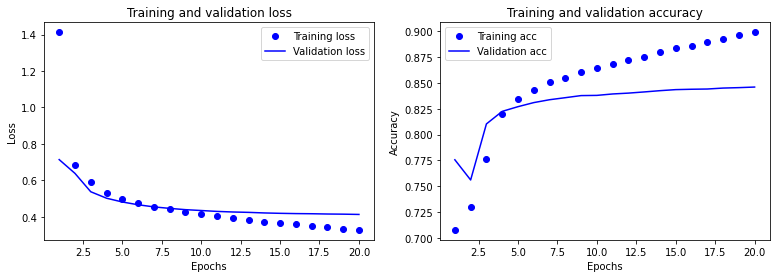

In [66]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(13,4))
ax1 = fig.add_subplot(1,2,1)
# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(-1, 1.5)
plt.legend()
ax2 = fig.add_subplot(1,2,2)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.5,1)
plt.legend()

plt.show()

---
---


## [결과 및 회고]

총 3가지의 모델 
* RNN - LSTM 사용 모델
* 1D CNN - GlobalMaxPooling1D() 사용 모델
* GlobalMaxPooling1D() 하나만 사용한 모델

을 통해 감성분석을 하였는데, 가장 성능이 좋은 모델은 __GlobalMaxPooling1D() 하나만 사용한 모델__ 이었습니다.  
__loss: 0.4186 - accuracy: 0.8436__ 결과를 얻을 수 있었습니다.   
처음에 정규화를 시키지 않았을 때는 accuracy가 약 82.7~ 8%로 비슷하긴 했지만 1d cnn > GlobalMaxPooling1D() > RNN - LSTM 의 순서로 높은 성능을 보였습니다.   
85%이상의 좋은 성능이 보이지 않아 Dropout 레이어 1개 추가하고 l1 정규화 층을 추가해준 후 accuracy 순서는 GlobaMaxPooling1D > RNN > 1D CNN 이였습니다.   
각각 모델에 word2vec 임베딩을 해준 후 성능의 차이는 크게 보이지 않았으나, Loss, Accuracy 그래프를 보면 GlobaMaxPooling1D 하나만 사용한 모델이 오버피팅이 잘 잡혔음을 볼 수 있었습니다.  

이번 프로젝트를 통해 NLP를 처음 접해서인지, 전체적인 자연어 처리과정 자체도 생소하고 어렵게 느껴졌습니다. 각각의 세부 파라미터들이 무엇을 의미하는지, 등을 파악하는 것도 쉽지 않았습니다. 또한 노드를 진행할 때는 word2vec 임베딩을 하기 전 후가 성능 차이가 매우 크게 났었는데, 한국어 감성 분석시에는 확연한 차이가 드러나지 않았고 심지어 그 전보다 결과가 낮게 나오기도 했습니다. 언어적 차이에 의한 것인지, 운이 안좋았던 것인지, 어떻게 하면 더 성능을 올릴 수 있을 지 궁금합니다.   
사실 1-D CNN + RNN 모델도 구현하려고 시도했으나 실패했습니다. 실패 원인은 input shape를 설정해주는데 있어 이해가 부족했기 때문입니다. 1dCNN과 RNN을 결합하려면 같은 형태의 input 값을 주었어야 했는데, 알맞은 input shape를 찾지 못했습니다. 이 부분에 관련하여 입력과 출력의 형태나 전체 흐름에 대해 잘 이해하기 위해 더 많은 공부를 할 것입니다.  
